In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict
import numpy as np
from sklearn import linear_model
import scipy.io as spio
from sklearn.multioutput import MultiOutputRegressor
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import shelve
import pandas as pd
import pickle
from sklearn.metrics import *
import time
import json

In [2]:
def evaluate_avg(model, X, y, n=100, scoring = 'r2'):
    #cv = KFold(n_splits=3, shuffle=True)
    scoreavg = 0
    for i in range(n):
        cv = KFold(n_splits=3, random_state = i)
        scores = cross_val_score(model, X=X, y=y, scoring = scoring, cv=cv)
        #print('Trial: %i, msle: %.3f' % (i, np.mean(scores)))
        scoreavg += np.mean(scores)
    scoreavg = scoreavg / n
    print(scoreavg)
    return scoreavg

In [3]:
def evaluate_avg_eigen(reg1, reg2, reg3, X, ydata, n = 100):
    #cv = KFold(n_splits=3, shuffle=True)
    scoreavg = np.array([0., 0., 0.])
    # B=(C11+2C12)/3
    B = (ydata[:,0] + 2. * ydata[:,1]) / 3.
    A = ydata[:,0] - ydata[:,1]
    C44 = ydata[:,2]
    C12 = ydata[:,1]
    for i in range(n):
        print(i)
        cv = KFold(n_splits=3, random_state = i)
        C11pred = cross_val_predict(reg1, X=X, y=ydata[:,0], cv = cv)
        C12pred = cross_val_predict(reg2, X=X, y=ydata[:,1], cv = cv)
        C44pred = cross_val_predict(reg3, X=X, y=ydata[:,2], cv = cv)
        Bpred = (C11pred + 2. * C12pred) / 3.
        Apred = C11pred - C12pred
        
        #print(pd.DataFrame({'A':A, 'Apred': Apred, 'C12': C12, 'C12pred': C12pred, 'C11': ydata[:,0], 'C11pred': C11pred}))
        
        df = pd.DataFrame({'Bpred': Bpred, 'Apred': Apred, 'C44pred': C44pred, 'B': B, 'A': A, 'C44': C44})
        df = df.drop(df[(df.Bpred<0) | (df.Apred<0) | (df.C44pred<0)].index)
        scoreavg += np.array([mean_squared_error(np.log(df.B), np.log(df.Bpred)), mean_squared_error(np.log(df.A), np.log(df.Apred)), mean_squared_error(np.log(df.C44), np.log(df.C44pred))])
        print(scoreavg)
    scoreavg = scoreavg / n
    return scoreavg

In [4]:
lattice = 'cubic'
column_names = ['avg atomic mass','vol per atom','std Li neighbor count','std Li bond ionicity','Li bond ionicity','Li neighbor count','Li-Li bonds per Li','avg Li bond length','sublattice bond ionicity','sublattice neighbor count','anion framework coordination','min anion-anion sep dist','vol per anion','min Li-anion sep dist','Li number conc','mass density','min Li-Li sep dist','sublattice electronegativity','RBI','RNB']
coeff=0
data = spio.loadmat(lattice+'-data-posd-features.mat')
xdatadf = pd.DataFrame(data['xdata'], columns = column_names)
#column_names_old = ['avg atomic mass','vol per atom','std Li neighbor count','std Li bond ionicity','Li bond ionicity','Li neighbor count','Li-Li bonds per Li','avg Li bond length','sublattice bond ionicity','sublattice neighbor count','anion framework coordination','min anion-anion sep dist','vol per anion','min Li-anion sep dist','Li number conc','mass density','min Li-Li sep dist','sublattice electronegativity','RBI','RNB']
column_names_for_ml = ['vol per atom','std Li neighbor count','std Li bond ionicity','Li bond ionicity','Li neighbor count','Li-Li bonds per Li','sublattice bond ionicity','sublattice neighbor count','anion framework coordination','min anion-anion sep dist','vol per anion','min Li-anion sep dist','mass density','min Li-Li sep dist','sublattice electronegativity','RBI','RNB']
X = xdatadf[column_names_for_ml].values
#X = np.hstack((xdatadf.values[:,:16],xdatadf.values[:,18:]))
y = data['ydata'][:,coeff]
X.shape

(170, 17)

In [5]:
ntdata = spio.loadmat(lattice+'-non-training-data-features.mat')
#Xnt=np.delete(Xnt,18,axis=1)
Xntdatadf = pd.DataFrame(ntdata['xntdata'],columns = column_names)
Xnt = Xntdatadf[column_names_for_ml].values

In [6]:
models_and_parameters = {
  'lasso': (linear_model.Lasso(),
              {'reg__alpha': [0.01, 0.1, 0.5, 1.,5.,10.]}),
    'elnet': (linear_model.ElasticNet(),
              {'reg__alpha':[0.01, 0.1, 0.5, 1, 5., 10.], 'reg__l1_ratio':[0.,0.1,0.5,1.,2.1]}),
    'krg': (KernelRidge(),
            {'reg__kernel':['rbf','linear'], 'reg__alpha': [1e0, 0.1, 1e-2, 1e-3], 'reg__gamma': np.logspace(-2, 2, 5)}),
    'gpr': (GaussianProcessRegressor(kernel = kernels.RBF()),
            {'reg__kernel__length_scale':[0.01, 0.1, 1., 2., 10., 100.], 'reg__kernel__length_scale_bounds':[(1e-2,1.),(1e-1,1.),(1e-1,10.),(1.,10.),(1.,100.)\
,(1e-2,1e2)]}),
    'gbr': (GradientBoostingRegressor(learning_rate=0.01, min_samples_split=2, max_features='sqrt', loss='ls', subsample=0.4),
            {'reg__max_depth': [2,3,4,10,20,50],'reg__min_samples_leaf': [2,3,4,10], 'reg__learning_rate':[0.01, 0.1], 'reg__max_features':['auto', 'sqrt', 'l\
og2']}),
    'ada': (AdaBoostRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=500,learning_rate=0.01),#max_depth alone doesn't work probably               
            {'reg__base_estimator__max_depth': [2,3,4,10], 'reg__base_estimator':[DecisionTreeRegressor(max_depth = 4, max_features='auto'),
                                                                                    DecisionTreeRegressor(max_depth = None, max_features='auto'),
                                                                                    DecisionTreeRegressor(max_depth = 4, max_features='sqrt'),
                                                                                     DecisionTreeRegressor(max_depth = None, max_features='sqrt')]}),
    'svr': (SVR(),
            {'reg__C': [0.01, 0.05, 0.1, 1], 'reg__kernel': ['linear', 'rbf']}),
    'rf': (RandomForestRegressor(),
           {'reg__max_depth': [None, 5, 10, 50]}),
    'brg': (linear_model.BayesianRidge(fit_intercept=True),
            {'reg__alpha_1': [1.e-6, 1.e-5]}),
    'lars': (linear_model.Lars(fit_intercept = True, normalize=False),
             {'reg__n_nonzero_coefs': [5, 10, 50, 500, np.inf]}),
    'ard': (linear_model.ARDRegression(),
            {'reg__alpha_1':[1.e-6, 1.e-5]})}

In [7]:
scaler = preprocessing.StandardScaler()
inner_cv = KFold(n_splits=3, shuffle=True)
outer_cv = KFold(n_splits=3, shuffle=True)

In [44]:
model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.01, loss='ls')
params = {'reg__max_depth': [2,3,4,10,20,50],
            'reg__min_samples_leaf': [2,3,4,10], 
            'reg__learning_rate':[0.01, 0.1], 
            'reg__max_features':['auto', 'sqrt', 'log2'],
            'reg__min_samples_split':[2,3,4]}
pipeline = Pipeline([('transformer', scaler), ('reg', model)])

In [45]:
reg1 = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv, n_jobs=-1)

In [36]:
#Without Grid
model = GradientBoostingRegressor(n_estimators = 500, 
                                learning_rate = 0.01, 
                                  max_depth = 3, 
                                max_features = 'auto', 
                                  min_samples_leaf = 2, 
                                  min_samples_split = 3)
                                  #subsample = 0.4)
pipeline = Pipeline([('transformer', scaler), ('reg', model)])
reg1 = Pipeline([('transformer', scaler), ('reg', model)])

In [27]:
#One with GridSearch
start_time = time.time()
reg1.fit(X,y)
print(reg1.best_params_)
r2scores=cross_val_score(reg1, X=X, y=y, scoring='r2',cv=outer_cv, n_jobs = -1)
print(r2scores)
print('Cross-validation results:')
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))
print("Time elapsed:  %s seconds" % (time.time() - start_time))

{'reg__learning_rate': 0.01, 'reg__max_depth': 4, 'reg__max_features': 'auto', 'reg__min_samples_leaf': 3, 'reg__min_samples_split': 3}
[0.52997895 0.5886626  0.63435822]
Cross-validation results:
Folds: 3, mean r2: 0.584
Time elapsed:  181.0330228805542 seconds


In [50]:
#One with GridSearch
start_time = time.time()
reg1.fit(X,y)
print(reg1.best_params_)
r2scores=cross_val_score(reg1.best_estimator_, X=X, y=y, scoring='r2',cv=outer_cv)
print(r2scores)
print('Cross-validation results:')
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))
evaluate_avg(reg1.best_estimator_, X, data['ydata'][:,0], n = 10 , scoring='neg_mean_squared_log_error')
print("Time elapsed:  %s seconds" % (time.time() - start_time))

{'reg__learning_rate': 0.01, 'reg__max_depth': 20, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 10, 'reg__min_samples_split': 2}
[0.71925126 0.67068838 0.48997001]
Cross-validation results:
Folds: 3, mean r2: 0.627
-0.12681125861939985
Time elapsed:  26.83945083618164 seconds


In [13]:
#Without Grid Search
r2avg = 0
ntimes = 100
for i in range(ntimes):
    outer_cv = KFold(n_splits=3, shuffle=True)
    #reg1.fit(X,y)
    r2scores=cross_val_score(reg1, X=X, y=y, scoring='neg_mean_squared_log_error', cv=outer_cv)
    #print(r2scores)
    #print('Cross-validation results:')
    print('Trial: %i, msle: %.3f' % (i, np.mean(r2scores)))
    #if np.mean(r2scores)>0.694:
    #    print('FOUND')
    #    break
    r2avg += np.mean(r2scores)
r2avg = r2avg/ntimes
print(r2avg)

Trial: 0, msle: -0.112
Trial: 1, msle: -0.122
Trial: 2, msle: -0.115
Trial: 3, msle: -0.120
Trial: 4, msle: -0.123
Trial: 5, msle: -0.123
Trial: 6, msle: -0.131
Trial: 7, msle: -0.128
Trial: 8, msle: -0.125
Trial: 9, msle: -0.173
Trial: 10, msle: -0.113
Trial: 11, msle: -0.116
Trial: 12, msle: -0.115
Trial: 13, msle: -0.118
Trial: 14, msle: -0.134
Trial: 15, msle: -0.127
Trial: 16, msle: -0.126
Trial: 17, msle: -0.131
Trial: 18, msle: -0.132
Trial: 19, msle: -0.136
Trial: 20, msle: -0.108
Trial: 21, msle: -0.137
Trial: 22, msle: -0.125
Trial: 23, msle: -0.113
Trial: 24, msle: -0.105
Trial: 25, msle: -0.112
Trial: 26, msle: -0.146
Trial: 27, msle: -0.121
Trial: 28, msle: -0.152
Trial: 29, msle: -0.130
Trial: 30, msle: -0.120
Trial: 31, msle: -0.112
Trial: 32, msle: -0.113
Trial: 33, msle: -0.134
Trial: 34, msle: -0.124
Trial: 35, msle: -0.126
Trial: 36, msle: -0.149
Trial: 37, msle: -0.127
Trial: 38, msle: -0.115
Trial: 39, msle: -0.110
Trial: 40, msle: -0.121
Trial: 41, msle: -0.136
Tr

In [89]:
evaluate_avg(reg1.best_estimator_, X, data['ydata'][:,0], n = 10 , scoring='r2')
evaluate_avg(reg2.best_estimator_, X, data['ydata'][:,1], n = 10 , scoring='r2')
evaluate_avg(reg3.best_estimator_, X, data['ydata'][:,2], n = 10 , scoring='r2')

0.5960364837923957
0.7887987628937134
0.5985546569333622


0.5985546569333622

In [76]:
evaluate_avg(reg2.best_estimator_, X, data['ydata'][:,1], n = 10)# , scoring='neg_mean_squared_log_error')

0.790160174748328


0.790160174748328

In [53]:
print(reg1.best_params_)

{'reg__learning_rate': 0.01, 'reg__max_depth': 20, 'reg__max_features': 'sqrt', 'reg__min_samples_leaf': 10, 'reg__min_samples_split': 2}


In [15]:
reg1.fit(X, y)
reg1.predict(Xnt)
#ynt1

array([ 41.45193496,  43.91545247,  45.78645338,  71.35070792,
        51.89575509,  51.30420475,  50.06252435,  50.74518816,
       102.4470744 ,  44.44713518,  51.79150381,  37.31184781,
        96.01958333,  88.20957289,  53.69860629, 100.26931705,
        91.38796468,  53.42966409, 125.13060459,  52.60222808,
        41.97245201,  48.05725139,  54.91357628,  30.51334783,
        48.05725139, 102.14173732,  46.84629001,  46.29390671,
        48.83438522,  45.88097651,  38.61391444, 113.48692407,
        44.20056299, 188.53056241,  33.07573739,  50.50528864,
        55.66285159,  44.31815834,  48.22864343,  58.91773608,
        45.77416061,  28.78686576,  97.33291543,  53.74932121,
       138.77310718,  54.10949093,  56.69885165,  72.52422406,
        67.67893934,  89.05531698,  65.16844138,  55.2602971 ,
        68.35683223,  40.61002481,  98.36296065,  64.48588665,
       149.23866696,  50.92964281, 128.46944698, 104.05962472,
        69.65803834,  54.2878039 , 102.01054542,  73.57

0.11207365770389698

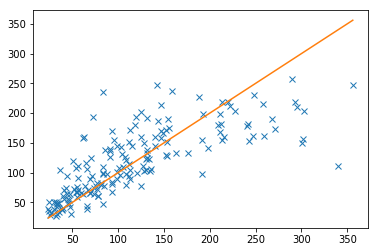

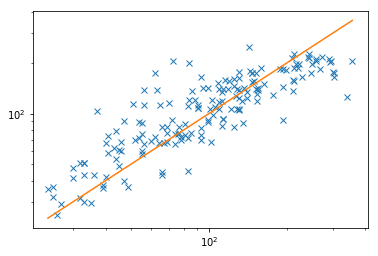

<Figure size 432x288 with 0 Axes>

In [9]:
y = data['ydata'][:,0]
plt.plot(y, cross_val_predict(reg1.best_estimator_, X, y, cv = outer_cv),'x')
plt.plot(np.linspace(min(y), max(y), 100), np.linspace(min(y), max(y), 100))

plt.figure()
plt.loglog(y, cross_val_predict(reg1.best_estimator_, X, y, cv = outer_cv), 'x')
plt.loglog(np.linspace(min(y), max(y), 100), np.linspace(min(y), max(y), 100))
plt.figure()
#plt.loglog(y, reg1.predict(X),'x')
#plt.loglog(np.linspace(min(y), max(y), 100), np.linspace(min(y), max(y), 100))
mean_squared_log_error(y, cross_val_predict(reg1.best_estimator_, X, y, cv = inner_cv))

In [55]:
s = pickle.dump(reg1,open( "reg1_featuresT.p", "wb" ))

In [62]:
coeff = 1
y = data['ydata'][:,coeff]
params = {'reg__kernel': ['rbf','linear'], 'reg__alpha': [1e0, 0.1, 1e-2, 1e-3], 'reg__gamma': np.logspace(-2, 2, 5)}
scaler = preprocessing.StandardScaler()
inner_cv = KFold(n_splits=3, shuffle=True)
outer_cv = KFold(n_splits=3, shuffle=True)

In [63]:
model = KernelRidge()
scaler = preprocessing.StandardScaler()
pipeline = Pipeline([('transformer', scaler), ('reg', model)])
reg2 = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv,n_jobs=-1)

In [57]:
reg2.fit(X,y)
print(reg2.best_params_)


{'reg__alpha': 0.01, 'reg__gamma': 0.0016681005372000592, 'reg__kernel': 'rbf'}


In [70]:
reg2.fit(X,y)
print(reg2.best_params_)
scores=cross_val_score(reg2.best_estimator_, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg2.best_estimator_, X=X, y=y, scoring='r2',cv=outer_cv)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))
evaluate_avg(reg2.best_estimator_, X, data['ydata'][:,1], n = 10 , scoring='r2')

{'reg__alpha': 0.01, 'reg__gamma': 0.011937766417144358, 'reg__kernel': 'rbf'}
Cross-validation results:
Folds: 3, mean RMSE: 17.925
Folds: 3, mean r2: 0.806
0.790160174748328


0.790160174748328

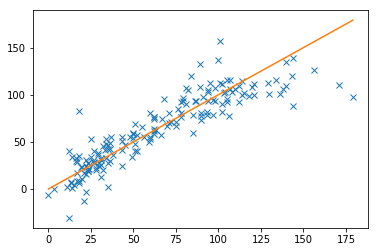

In [69]:

y = data['ydata'][:,1]
plt.plot(y, cross_val_predict(reg2.best_estimator_, X, y, cv = outer_cv),'x')
plt.plot(np.linspace(min(y), max(y), 100), np.linspace(min(y), max(y), 100))



In [70]:
s = pickle.dump(reg2,open( "reg2_featuresT.p", "wb" ))

In [74]:
coeff=2
y = data['ydata'][:,coeff]
params = {'reg__max_depth': [2,3,4,10,20,50],
            'reg__min_samples_leaf': [2,3,4,10], 
            'reg__learning_rate':[0.01, 0.1], 
            'reg__max_features':['auto', 'sqrt', 'log2'],
            'reg__min_samples_split':[2,3,4]}
scaler = preprocessing.StandardScaler()
inner_cv = KFold(n_splits=3, shuffle=True)
outer_cv = KFold(n_splits=3, shuffle=True)
model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.01, loss='ls')
scaler = preprocessing.StandardScaler()
pipeline = Pipeline([('transformer', scaler), ('reg', model)])

In [78]:
reg3 = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv, n_jobs=-1)
#model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.1, min_samples_split=2, max_features='sqrt', loss='ls', subsample=0.4)
#reg3 = Pipeline([('transformer', scaler), ('reg', model)])
reg3.fit(X,y)
reg3.best_params_

{'reg__learning_rate': 0.01,
 'reg__max_depth': 3,
 'reg__max_features': 'auto',
 'reg__min_samples_leaf': 4,
 'reg__min_samples_split': 4}

In [79]:
scores=cross_val_score(reg3.best_estimator_, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg3.best_estimator_, X=X, y=y, scoring='r2',cv=outer_cv)
print(r2scores)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))
#evaluate_avg(reg3.best_estimator_, X, data['ydata'][:,2], n = 10 , scoring='neg_mean_squared_log_error')

[0.71655507 0.68021147 0.5789467 ]
Cross-validation results:
Folds: 3, mean r2: 0.659


In [137]:
#Without GridSearch
model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.1, min_samples_split=4, max_features='sqrt', min_samples_leaf = 2, max_depth = 2, loss='ls', subsample=0.4)
reg3 = Pipeline([('transformer', scaler), ('reg', model)])
reg3.fit(X,y)
#print(reg3.best_params_)
scores=cross_val_score(reg3, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg3, X=X, y=y, scoring='r2',cv=outer_cv)
print(r2scores)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
#print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))

[0.73269703 0.73732528 0.68948877]
Cross-validation results:
Folds: 3, mean r2: 0.720


<Figure size 432x288 with 0 Axes>

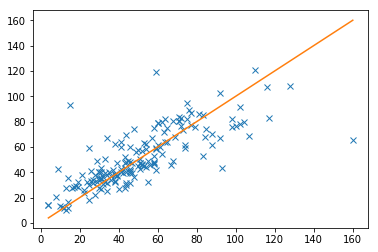

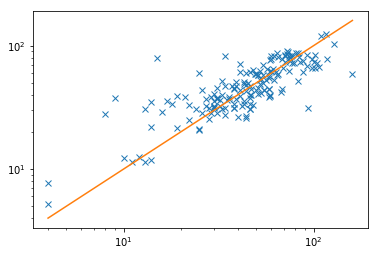

<Figure size 432x288 with 0 Axes>

In [80]:
y = data['ydata'][:,2]
plt.plot(y, cross_val_predict(reg3.best_estimator_, X, y, cv = outer_cv),'x')
plt.plot(np.linspace(min(y), max(y), 100), np.linspace(min(y), max(y), 100))

plt.figure()
plt.loglog(y, cross_val_predict(reg3.best_estimator_, X, y, cv = outer_cv), 'x')
plt.loglog(np.linspace(min(y), max(y), 100), np.linspace(min(y), max(y), 100))
plt.figure()
#mean_squared_log_error(y, cross_val_predict(reg3.best_estimator_, X, y, cv = inner_cv))


In [81]:
s = pickle.dump(reg3,open( "reg3_featuresT.p", "wb" ))

In [80]:
y1t=reg1.predict(X)
y2t=reg2.predict(X)
y3t=reg3.predict(X)
e1t=(y1t+2*y2t)/3
e2t=(y1t-y2t)
e3t=y3t
yall = data['ydata']
print(mean_squared_error(y1t,yall[:,0]))
print(mean_squared_error(y2t,yall[:,1]))
print(mean_squared_error(y3t,yall[:,2]))
print(mean_squared_error(e1t,(yall[:,0]+2.*yall[:,1])/3.))
print(mean_squared_error(e2t,yall[:,0]-yall[:,1]))
print(mean_squared_error(e3t,yall[:,2]))
print()
print(r2_score(y1t,yall[:,0]))
print(r2_score(y2t,yall[:,1]))
print(r2_score(y3t,yall[:,2]))
print(r2_score(e1t,(yall[:,0]+2.*yall[:,1])/3.))
print(r2_score(e2t,yall[:,0]-yall[:,1]))
print(r2_score(e3t,yall[:,2]))

326.4498589301878
109.05777762156247
43.11011863906521
121.4048790966785
270.5261653249157
43.11011863906521

0.9262528643532584
0.9237169460220372
0.9229236843378863
0.9336655428103484
0.89954411574077
0.9229236843378863


In [99]:
yall = data['ydata']
y1t=cross_val_predict(reg1.best_estimator_, X, yall[:,0])
y2t=cross_val_predict(reg2.best_estimator_, X, yall[:,1])
y3t=cross_val_predict(reg3.best_estimator_, X, yall[:,2])
e1t=(y1t+2*y2t)/3.
e2t=(y1t-y2t)
e3t=y3t

print(mean_squared_error(y1t,yall[:,0]))
print(mean_squared_error(y2t,yall[:,1]))
print(mean_squared_error(y3t,yall[:,2]))
print(mean_squared_error(e1t,(yall[:,0]+2.*yall[:,1])/3.))
print(mean_squared_error(e2t,yall[:,0]-yall[:,1]))
print(mean_squared_error(e3t,yall[:,2]))
print()
print(r2_score(y1t,yall[:,0]))
print(r2_score(y2t,yall[:,1]))
print(r2_score(y3t,yall[:,2]))
print(r2_score(e1t,(yall[:,0]+2.*yall[:,1])/3.))
print(r2_score(e2t,yall[:,0]-yall[:,1]))
print(r2_score(e3t,yall[:,2]))

2204.8457212839908
328.3097956192837
289.35815795622455
569.1285531437883
1731.1194796367902
289.35815795622455

0.2327242844126053
0.7723757269303794
0.17621246270290247
0.6170699200048227
0.11192337434109523
0.17621246270290247


In [83]:
y1nt=reg1.predict(Xnt) # it uses best est
y2nt=reg2.predict(Xnt)
y3nt=reg3.predict(Xnt)

In [84]:
ynt=np.column_stack((y1nt,y2nt,y3nt))
ynt.shape
spio.savemat(lattice+'-nt-featuresT-result',mdict={'coeffsnt':ynt,'coord':ntdata['coord'],'mps':ntdata['mps'],'volrat':ntdata['volrat']})

In [21]:
print(data['volratt'][0])

[0.2581988  0.38035522 0.38049773 0.25820269 0.38049772 0.08406202
 0.38049773 0.25820563 0.25820563 0.2581988  0.2581988  0.08406202
 0.25820563 0.08406202 0.25820563 0.25820563 0.25820563 0.25820563
 0.73524312 0.23805073 0.23356835 0.23244811 0.38049773 0.08406202
 0.25820563 0.08406202 0.15191745 0.15191745 0.05525574 0.25819966
 0.25820364 0.25820563 0.25819916 0.25819966 0.25820563 0.25819966
 0.25820121 0.25820563 0.25820392 0.25819651 0.25820563 0.14101352
 0.25820563 0.25820478 0.25820563 0.25820563 0.15191745 0.25820029
 0.25820336 0.2581988  0.25820563 0.25820563 0.15191745 0.2581988
 0.15191744 0.1579381  0.16420279 0.25820563 0.25820563 0.25820563
 0.2581988  0.25820364 0.25820051 0.25820563 0.25820563 0.25819966
 0.25820336 0.25819368 0.25820165 0.25820563 0.25820321 0.25820392
 0.25820165 0.0538958  0.25819872 0.25820563 0.25820563 0.25820563
 0.25820279 0.25819966 0.15191745 0.2581988  0.25820563 0.25819966
 0.25820336 0.25819966 0.25820078 0.14623936 0.15191735 0.25820

In [13]:
ytr = np.column_stack((cross_val_predict(reg1.best_estimator_, X, data['ydata'][:,0], cv = inner_cv), cross_val_predict(reg2.best_estimator_, X, data['ydata'][:,1], cv = inner_cv), cross_val_predict(reg3.best_estimator_, X, data['ydata'][:,2], cv = inner_cv)))
ytr.shape
spio.savemat(lattice+'-tr-featuresT-result',mdict={'coeffstr':data['ydata'],'coeffspred':ytr,'coord':data['coordt'],'mps':data['mps'],'volrat':data['volratt']})

In [10]:
with open('reg1_featuresT.p','rb') as f:
    reg1=pickle.load(f)

In [11]:
with open('reg2_featuresT.p','rb') as f:
    reg2 = pickle.load(f)

In [12]:
with open('reg3_featuresT.p','rb') as f:
    reg3 = pickle.load(f)

In [113]:
dd = spio.loadmat(lattice+'-nt-featuresT-result')
dj = {}
dj['coeffsnt']=dd['coeffsnt'].tolist()
dj['coord']=dd['coord'].tolist()
dj['volrat']=dd['volrat'].tolist()
dj['mps']=dd['mps'].tolist()

In [118]:

with open(lattice+'-nt-featuresT-result.json','w') as f:
    json.dump(dj,f)

In [13]:
model = linear_model.Lasso()
params = models_and_parameters['lasso'][1]
scaler = preprocessing.StandardScaler()
pipeline = Pipeline([('transformer', scaler), ('reg', model)])
reg1lasso = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv,n_jobs=-1)
reg2lasso = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv,n_jobs=-1)
reg3lasso = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv,n_jobs=-1)
reg1lasso
reg2lasso

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('transformer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'reg__alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
yall = data['ydata']
reg1lasso.fit(X,yall[:,0])
reg2lasso.fit(X,yall[:,1])
reg3lasso.fit(X,yall[:,2])

#reg1lasso.best_params_
#scores=cross_val_score(reg2, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores1=cross_val_score(reg1lasso.best_estimator_, X=X, y=yall[:,0], scoring='r2',cv=outer_cv)
r2scores2=cross_val_score(reg2lasso.best_estimator_, X=X, y=yall[:,1], scoring='r2',cv=outer_cv)
r2scores3=cross_val_score(reg3lasso.best_estimator_, X=X, y=yall[:,2], scoring='r2',cv=outer_cv)
#rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
#print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))
print(np.mean(r2scores1))
print(np.mean(r2scores2))
print(np.mean(r2scores3))


Cross-validation results:
0.513331848764356
0.7772766216811924
0.5095895691543103


In [111]:
reg1lasso

GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('transformer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'reg__alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [16]:
print(reg1lasso.best_estimator_.named_steps['reg'].coef_)
print(reg2lasso.best_estimator_.named_steps['reg'].coef_)
print(reg3lasso.best_estimator_.named_steps['reg'].coef_)

[-28.0188192    0.           0.          -0.           8.17570669
  -0.          -0.           8.40619176   0.          -0.
  -6.62068896  -0.          20.24050802  11.37085611  -0.
   0.           0.        ]
[-18.70581901  -2.78651373  -0.           0.62370412   2.14768122
 -11.45552768   0.34575328   2.86283602  -1.10571262  -0.
   0.           1.75217245  19.18970969   3.25901368  -1.4272462
   3.82644862  -0.        ]
[-17.72432672  -1.39608121  -0.65669383   4.03446819   0.
  -1.55121757   0.           3.41081608   2.61176946  -0.
  -0.88207484  -0.18698705   1.98841239   1.44946146  -7.87904663
   5.0162746    0.        ]


In [180]:
#X2 = X[:,[0,1,4,5,7,12,13,14,15]] 
#X = X2
coeff = 1
y = data['ydata'][:,coeff]
params = {'reg__kernel': ['rbf','linear'], 'reg__alpha': [1e0, 0.1, 1e-2, 1e-3], 'reg__gamma': np.logspace(-2, 2, 5)}
scaler = preprocessing.StandardScaler()
inner_cv = KFold(n_splits=3, shuffle=True)
outer_cv = KFold(n_splits=3, shuffle=True)
model = KernelRidge()
scaler = preprocessing.StandardScaler()
pipeline = Pipeline([('transformer', scaler), ('reg', model)])
reg2 = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv,n_jobs=-1)

reg2.fit(X,y)
print(reg2.best_params_)
scores=cross_val_score(reg2.best_estimator_, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg2.best_estimator_, X=X, y=y, scoring='r2',cv=outer_cv)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
print('Folds: %i, mean RMSE: %.3f' % (len(scores), np.mean(np.abs(rmse_scores))))
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))
evaluate_avg(reg2.best_estimator_, X, data['ydata'][:,1], n = 10 , scoring='r2')

{'reg__alpha': 0.01, 'reg__gamma': 0.01, 'reg__kernel': 'rbf'}
Cross-validation results:
Folds: 3, mean RMSE: 16.966
Folds: 3, mean r2: 0.830
0.8094063911469549


0.8094063911469549

In [189]:
#X = X[:,[0,1,2,5,7,8,12,13,14,15]]
coeff=2
y = data['ydata'][:,coeff]
params = {'reg__max_depth': [2,3,4,10,20,50],
            'reg__min_samples_leaf': [2,3,4,10], 
            'reg__learning_rate':[0.01, 0.1], 
            'reg__max_features':['auto', 'sqrt', 'log2'],
            'reg__min_samples_split':[2,3,4]}
scaler = preprocessing.StandardScaler()
inner_cv = KFold(n_splits=3, shuffle=True)
outer_cv = KFold(n_splits=3, shuffle=True)
model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.01, loss='ls')
scaler = preprocessing.StandardScaler()
pipeline = Pipeline([('transformer', scaler), ('reg', model)])

reg3 = GridSearchCV(estimator=pipeline, param_grid=params, cv=inner_cv, n_jobs=-1)
#model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.1, min_samples_split=2, max_features='sqrt', loss='ls', subsample=0.4)
#reg3 = Pipeline([('transformer', scaler), ('reg', model)])
reg3.fit(X,y)
reg3.best_params_

scores=cross_val_score(reg3.best_estimator_, X=X, y=y, scoring='neg_mean_squared_error',cv=outer_cv)
r2scores=cross_val_score(reg3.best_estimator_, X=X, y=y, scoring='r2',cv=outer_cv)
print(r2scores)
rmse_scores = [np.sqrt(abs(s)) for s in scores]
print('Cross-validation results:')
print('Folds: %i, mean r2: %.3f' % (len(r2scores), np.mean(r2scores)))
evaluate_avg(reg3.best_estimator_, X, data['ydata'][:,2], n = 10)

[0.68515192 0.68010439 0.58793298]
Cross-validation results:
Folds: 3, mean r2: 0.651
0.6028318873166738


0.6028318873166738

In [13]:
with open('reg2_features.p','rb') as f:
    reg2 = pickle.load(f)
with open('reg1_features.p','rb') as f:
    reg1 = pickle.load(f)

In [17]:
coef1=reg1lasso.best_estimator_.named_steps['reg'].coef_
coef2=reg2lasso.best_estimator_.named_steps['reg'].coef_
coef3=reg3lasso.best_estimator_.named_steps['reg'].coef_
print(np.abs(coef1).argsort()[-5:][::-1]+1)
print(np.abs(coef2).argsort()[-5:][::-1]+1)
print(np.abs(coef3).argsort()[-5:][::-1]+1)

[ 1 13 14  8  5]
[13  1  6 16 14]
[ 1 15 16  4  8]


In [18]:
print([column_names_for_ml[a] for a in np.abs(coef1).argsort()[-5:][::-1]])
print([column_names_for_ml[a] for a in np.abs(coef2).argsort()[-5:][::-1]])
print([column_names_for_ml[a] for a in np.abs(coef3).argsort()[-5:][::-1]])

['vol per atom', 'mass density', 'min Li-Li sep dist', 'sublattice neighbor count', 'Li neighbor count']
['mass density', 'vol per atom', 'Li-Li bonds per Li', 'RBI', 'min Li-Li sep dist']
['vol per atom', 'sublattice electronegativity', 'RBI', 'Li bond ionicity', 'sublattice neighbor count']


In [77]:
bb = scaler.fit(X)
X1=bb.transform(X)
pd.DataFrame(X1).head()



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,-0.982106,-0.361394,-0.141718,0.117372,-1.177644,-0.175505,1.444946,-0.537715,0.872549,-0.198931,0.695694,0.630247,0.443861,-0.002837,2.160390,-0.917639,-1.286106,0.02752,-0.917669
1,0.540093,-0.379834,-0.141718,0.648068,0.173565,0.672964,0.679151,0.981684,-1.333768,0.726501,-0.791508,-1.631712,-1.499989,-0.185322,-0.489298,0.775349,2.467324,0.02752,0.775313
2,2.492513,-0.406770,-0.141718,0.787799,0.341157,0.672964,0.679151,0.934815,-1.273321,0.726501,-0.791508,-1.642058,-1.507777,-0.205570,-0.478428,2.979259,2.467324,0.02752,2.979235
3,-0.858659,0.415251,-0.141718,-0.091346,-1.334761,-0.175505,1.444946,0.601244,0.464531,-0.198931,0.695694,1.068522,1.117473,0.554601,1.410794,-0.987999,-1.286106,0.02752,-0.988034
4,3.183015,-0.295111,-0.141718,-1.482809,1.021999,0.672964,-0.699280,1.127459,-1.624131,0.726501,0.058322,-1.599527,-1.616698,-0.121565,-1.173835,3.567170,6.583990,0.02752,3.567147


In [112]:
#Old
lattice = 'cubic'
coeff=0
data = spio.loadmat(lattice+'-data-posd-with-den.mat')
X = data['xdata']
y = data['ydata'][:,coeff]
X1=np.delete(X,18,axis=1)
print(X1.shape)
X1[2,:]
X=X1
data['mps']

(170, 19)


array(['mp-976334', 'mp-861936', 'mp-861931', 'mp-867226', 'mp-30765 ',
       'mp-23259 ', 'mp-11248 ', 'mp-1646  ', 'mp-23222 ', 'mp-976023',
       'mp-976256', 'mp-22905 ', 'mp-934   ', 'mp-1138  ', 'mp-11489 ',
       'mp-1934  ', 'mp-1437  ', 'mp-2012  ', 'mp-30764 ', 'mp-567395',
       'mp-569849', 'mp-11644 ', 'mp-10890 ', 'mp-23703 ', 'mp-2743  ',
       'mp-22899 ', 'mp-2286  ', 'mp-1153  ', 'mp-755309', 'mp-865868',
       'mp-865866', 'mp-861629', 'mp-862297', 'mp-867196', 'mp-16349 ',
       'mp-865912', 'mp-867927', 'mp-865793', 'mp-867834', 'mp-865444',
       'mp-867253', 'mp-542435', 'mp-3201  ', 'mp-865231', 'mp-10180 ',
       'mp-31168 ', 'mp-5920  ', 'mp-862657', 'mp-864598', 'mp-861616',
       'mp-862316', 'mp-16271 ', 'mp-12558 ', 'mp-864631', 'mp-7575  ',
       'mp-3887  ', 'mp-13944 ', 'mp-21026 ', 'mp-11947 ', 'mp-11512 ',
       'mp-862321', 'mp-861896', 'mp-864930', 'mp-21029 ', 'mp-12411 ',
       'mp-861666', 'mp-865872', 'mp-861901', 'mp-865582', 'mp-8

In [89]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,29.7050,14.929776,0.0,0.444402,0.460,14.0,9.333333,2.864868,0.920000,14.0,12.000000,4.387422,59.719105,2.825278,0.050235,3.303811,0.5,1.0,3.303971
1,81.5500,14.847659,0.0,0.591787,0.976,18.0,6.000000,3.139741,0.271111,18.0,8.000000,2.758826,19.796879,2.758758,0.016838,9.120210,3.6,1.0,9.120451
2,148.0480,14.727705,0.0,0.630593,1.040,18.0,6.000000,3.131262,0.288889,18.0,8.000000,2.751377,19.636940,2.751377,0.016975,16.691922,3.6,1.0,16.692338
3,33.9095,18.388386,0.0,0.386437,0.400,14.0,9.333333,3.070916,0.800000,14.0,12.000000,4.702977,73.553543,3.028477,0.040787,3.062081,0.5,1.0,3.062221
4,171.5660,15.224955,0.0,0.000000,1.300,18.0,0.000000,3.166113,0.185714,18.0,10.285714,2.781999,17.399948,2.781999,0.008210,18.711737,7.0,1.0,18.712191


In [12]:
evaluate_avg_eigen(reg1.best_estimator_, reg2.best_estimator_, reg3.best_estimator_, X, ydata = data['ydata'], n=100)

0
[0.11623739 1.10398769 0.16393518]
1
[0.24409226 2.03288424 0.3264828 ]
2
[0.36173804 3.00150754 0.4912046 ]
3
[0.47296084 3.96392383 0.6531068 ]
4
[0.58534989 5.08970036 0.81873867]
5
[0.71494474 6.36755544 0.98253774]
6
[0.84403966 7.57184265 1.14725341]
7
[0.96195843 8.70536127 1.31361589]
8
[1.0882026  9.74544024 1.47745324]
9
[ 1.20394349 10.89746363  1.641608  ]
10
[ 1.31533406 11.92543675  1.80540446]
11
[ 1.44487816 13.06374197  1.97035225]
12
[ 1.5773358  14.05511043  2.13423373]
13
[ 1.7104024  15.1263076   2.29993465]
14
[ 1.82992392 16.33154462  2.46400409]
15
[ 1.9405804  17.53482071  2.62905803]
16
[ 2.05247766 18.65426443  2.79424417]
17
[ 2.16920236 19.67794401  2.95753893]
18
[ 2.27728891 20.65855829  3.12066153]
19
[ 2.40066586 21.57432587  3.28303156]
20
[ 2.54838804 22.69109024  3.44848399]
21
[ 2.67581437 23.8036153   3.61254219]
22
[ 2.79479334 24.8385071   3.77809164]
23
[ 2.91248857 25.89690537  3.9430374 ]
24
[ 3.03097505 27.42263733  4.10887806]
25
[ 3.14620

array([0.11819708, 1.07956425, 0.1643363 ])

In [82]:
reg1

Pipeline(memory=None,
     steps=[('transformer', StandardScaler(copy=True, with_mean=True, with_std=True)), ('reg', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3,
             max_features='auto', max_leaf_nodes=None,
             min_impurit...       presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False))])

In [98]:
model = GradientBoostingRegressor(n_estimators = 500, learning_rate=0.01, min_samples_split=2, max_features='sqrt', loss='ls', subsample=0.4)
model.set_params(**reg3grid.best_params_)
reg3 = Pipeline([('transformer', scaler), ('reg', model)])

ValueError: Invalid parameter reg for estimator GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=0.4, verbose=0,
             warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [103]:
data['ydata']

array([[ 46.,  31.,  33.],
       [154., 107.,  60.],
       [258., 140., 107.],
       [ 30.,  23.,  26.],
       [303., 179., 100.],
       [ 37.,  13.,  19.],
       [119.,  89.,  34.],
       [ 33.,  22.,  18.],
       [ 39.,  23.,  40.],
       [ 33.,  23.,  27.],
       [ 24.,  17.,  14.],
       [ 54.,  21.,  25.],
       [ 45.,  25.,  22.],
       [125.,  43.,  59.],
       [ 40.,  36.,  30.],
       [ 56.,  35.,  44.],
       [ 41.,  32.,  31.],
       [ 44.,  25.,  22.],
       [198., 106.,  93.],
       [ 41.,  22.,  16.],
       [ 47.,  21.,  30.],
       [ 25.,  12.,   8.],
       [135.,  29.,  38.],
       [ 84.,  12.,  48.],
       [ 93.,  63.,  41.],
       [ 36.,  13.,  14.],
       [ 66.,  17.,  28.],
       [ 83.,  19.,  34.],
       [ 30.,   0.,   4.],
       [192., 112.,  51.],
       [147., 136.,  36.],
       [131., 103.,  60.],
       [222., 112.,  71.],
       [ 70.,  67.,  47.],
       [140., 129.,  98.],
       [112.,  94.,  72.],
       [356., 156., 117.],
 